In [8]:
import os
import sys
import time
import numpy as np
import cv2
from glob import glob

from utils.homography import compute_h, cor_p
from utils.triangulation import triangulation
from pathlib import Path
from shapely.geometry import Polygon
from matplotlib import pyplot as plt

In [9]:
def kmeans(im, numWords=5):
    r, c = im.shape[:-1]
    step = 2

    rgbs = []
    for x in range(0, c, step):
        for y in range(0, r, step):
            rgbs.append(im[y][x].tolist())
    rgbs = np.array(rgbs, dtype=np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, _, vocab = cv2.kmeans(rgbs, numWords, None, criteria, attempts, flags)

    vocab_col = [[max(0, min(255, c)) for c in word] for word in vocab]
    return vocab, vocab_col

def clustering(im):
    start_time = time.time()
    r, c = im.shape[:-1]
    vocab, vocab_col = kmeans(im)

    bf = cv2.BFMatcher()
    rgbs = []
    for x in range(c):
        for y in range(r):
            rgbs.append(im[y][x].tolist())
    rgbs = np.array(rgbs, dtype=np.float32)
    matches = bf.knnMatch(rgbs, vocab, k=1)

    out = np.array([[vocab_col[matches[x * r + y][0].trainIdx] for x in range(c)] for y in range(r)], dtype=np.uint8)
    print('Clustering time: {:6}s'.format(time.time() - start_time))
    return out

Clustering time: 0.3614366054534912s
Clustering time: 0.27518367767333984s
Clustering time: 0.24291682243347168s
Clustering time: 0.7590396404266357s
Clustering time: 0.34868454933166504s


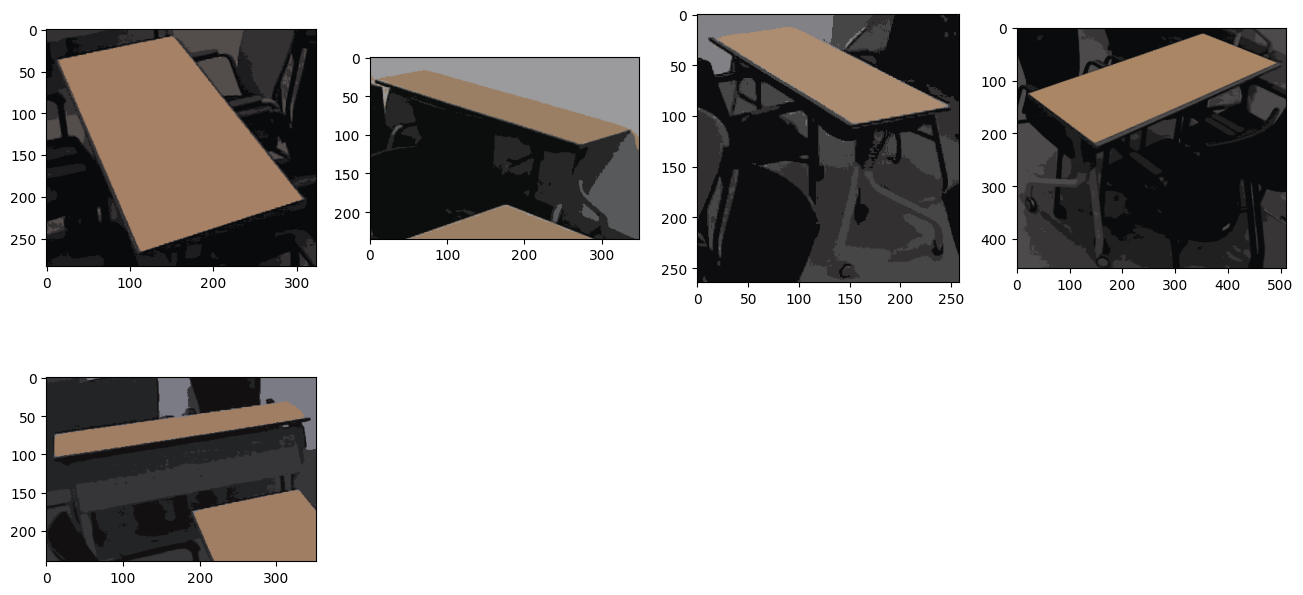

In [16]:
dir_path = "runs/detect/layout/cam1/crops/dining table/"

imgs = glob(os.path.join(dir_path, '*.jpg'))
plt.figure(figsize=(16,16))
for i, p in enumerate(imgs):
    im = cv2.imread(p)
    out = clustering(im)
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i+1)
    plt.imshow(out)
